## **Quantum Amplitude Estimation**

---



Given an operator **A** that acts as

$$
A|0\rangle = \sqrt{1 - a}\,|\Psi_0\rangle + \sqrt{a}\,|\Psi_1\rangle
$$

<br>

Quantum Amplitude Estimation (QAE) is the task of **estimating the amplitude** **a** of the state $ |\Psi_1\rangle $:

$$
a = |\langle \Psi_1 | \Psi_1 \rangle|^2.
$$

<br>

The original algorithm (Brassard et al., 2000) uses a combination of the Grover operator : $$ Q = A S_0 A^\dagger S_{\Psi_1}, $$

where  
- $ S_0 $ is a reflection about the $|0\rangle$ state,  
- $ S_{\Psi_1} $ is a reflection about $|\Psi_1\rangle$.

However, canonical QAE requires large circuits (QFT + controlled powers), so practical variants exist.


---

**Example: Bernoulli Random Variable**

In this example, **A** encodes a Bernoulli random variable with unknown success probability $ p $:

$$
A|0\rangle = \sqrt{1 - p}\,|0\rangle + \sqrt{p}\,|1\rangle.
$$

On a quantum computer, we can model this using a single-qubit rotation around the Y-axis:

$$
A = R_Y(\theta_p),\quad
\theta_p = 2\sin^{-1}(\sqrt{p}).
$$

The corresponding Grover operator becomes:

$$
Q = R_Y(2\theta_p),
$$

and its powers are easy to compute:

$$
Q^k = R_Y(2k\theta_p).
$$

---


In [1]:
p = 0.2

In [2]:
import numpy as np
from qiskit.circuit import QuantumCircuit


class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator"""

    def __init__(self, probability):
        super().__init__(1)

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)



class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator"""

    def __init__(self, probability):
        super().__init__(1)

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k


A = BernoulliA(p)
Q = BernoulliQ(p)

In [3]:

from qiskit_algorithms import EstimationProblem
from qiskit.primitives import Sampler

# setup sampler
sampler = Sampler()

# setup problem
problem = EstimationProblem(
    state_preparation=A,
    grover_operator=Q,
    objective_qubits=[0]
)

print(problem)

#### **1. Canonical AE**

---

In [4]:
from qiskit_algorithms import AmplitudeEstimation

# amplitude estimation
ae = AmplitudeEstimation(
    num_eval_qubits=3,
    sampler=sampler
)
print(ae)

In [5]:
ae_res = ae.estimate(problem)
print(ae_res)

{   'circuit_results': {   '000': 0.0225792,
                           '001': 0.0056448,
                           '010': 0.025088,
                           '011': 0.025088,
                           '100': 0.4532710064632,
                           '101': 0.0075289935367994,
                           '110': 0.0075289935367994,
                           '111': 0.4532710064632002},
    'confidence_interval': (0.19999999406856905, 0.19999999406856905),
    'confidence_interval_processed': (0.19999999406856905, 0.19999999406856905),
    'estimation': 0.1464466,
    'estimation_processed': 0.1464466,
    'max_probability': 0.9065420129264001,
    'measurements': {   0: 0.0225792,
                        1: 0.4532710064632,
                        2: 0.025088,
                        3: 0.0075289935367994,
                        4: 0.0056448,
                        5: 0.0075289935367994,
                        6: 0.025088,
                        7: 0.4532710064632002},
    'mle'

In [6]:
print(ae_res.estimation)

0.1464466


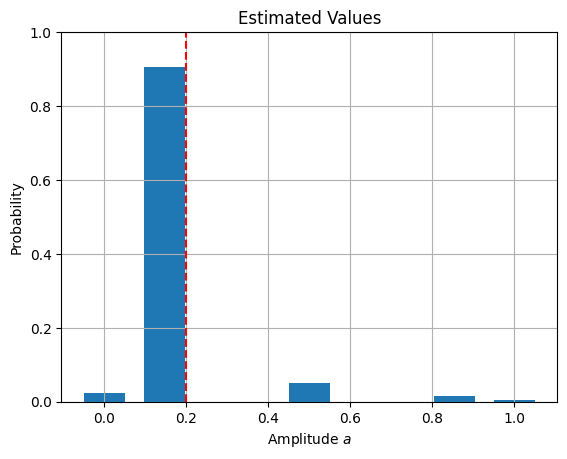

In [7]:
import matplotlib.pyplot as plt

gridpoints = list(ae_res.samples.keys())
probabilities = list(ae_res.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.title("Estimated Values")
plt.ylabel("Probability")
plt.xlabel(r"Amplitude $a$")
plt.ylim((0, 1))
plt.grid()
plt.show()

In [8]:
print(f'Interpolated result : {ae_res.mle}')

Interpolated result : 0.19999999406856905


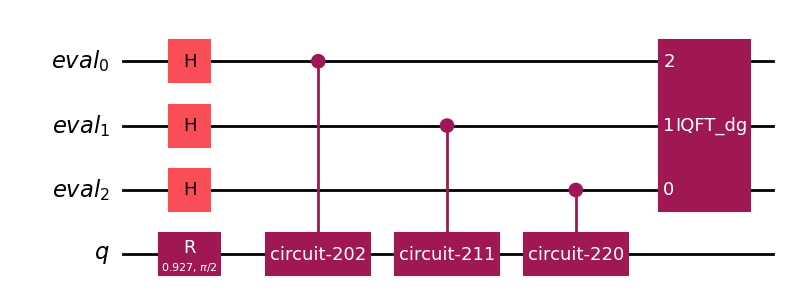

In [9]:
circuit = ae.construct_circuit(problem)
circuit.decompose().draw(output="mpl")

#### **2. Iterative AE**

---



Iterative AE removes the Quantum Phase Estimation (QPE) part of canonical AE and uses a
**binary-search–like strategy** to refine the amplitude estimate.

<br>

**Key Idea**

Run circuits with Grover powers $( k = 1, 3, 5, \dots )$  
Measure outcomes → update a confidence interval → pick the next \( k \).

<br>

**Pros**
- Much shallower than canonical AE.  
- Very NISQ-friendly.  
- Does not require controlled operations or QFT.

<br>

**Cons**
- No strict quadratic speedup.  
- Sequential rounds → more “runtime” overhead.


---

{   'alpha': 0.05,
    'circuit_results': None,
    'confidence_interval': [0.2, 0.2],
    'confidence_interval_processed': (0.2, 0.2),
    'epsilon_estimated': 0.0,
    'epsilon_estimated_processed': 0.0,
    'epsilon_target': None,
    'estimate_intervals': [[0.0, 1.0], [0.2, 0.2]],
    'estimation': 0.2,
    'estimation_processed': 0.2,
    'num_oracle_queries': 0,
    'powers': [0, 0],
    'ratios': [1.0],
    'shots': None,
    'theta_intervals': [[0, 0.25], [0.1475836176504333, 0.1475836176504333]]}

Estimation : 0.2


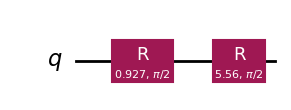

In [10]:
from qiskit_algorithms import IterativeAmplitudeEstimation

# setup IAE
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # desired precision
    alpha=0.05,           # confidence level
    sampler=sampler
)

iae_res = iae.estimate(problem)
print(iae_res)

print(f'\nEstimation : {iae_res.estimation}')

iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.decompose().draw(output="mpl")

#### **3. Maximum Likelihood AE**

---


MLAE is a **statistics-driven** version of Quantum Amplitude Estimation.

Instead of phase estimation, it collects measurement data from circuits run with different Grover powers and then fits the amplitude using **maximum likelihood estimation**.

<br>

**Key Idea**

We estimate the amplitude \( a \) by maximizing the likelihood function:

$$
L(a) = \prod_{k}
P_k(a)^{\,n_k}
\left(1 - P_k(a)\right)^{\,N_k - n_k},
$$

where

$$
P_k(a) = \sin^2\!\left( (2k+1)\,\theta \right),
\qquad
\theta = \arcsin(\sqrt{a}).
$$

Here:

- $ k $ = Grover iteration index  
- $ n_k$ = number of **good** measurement outcomes  
- $ N_k$ = total measurements for power ( k )

<br>

**Pros**

- Very robust to noise  
- No QFT required  
- No controlled Grover operations  
- Often the most practical choice for **real hardware**

<br>

**Cons**

- Requires more classical optimization  
- Theoretical error bounds slightly weaker than canonical AE

---


{   'circuit_results': [   {'0': 0.7999999999999999, '1': 0.2},
                           {'0': 0.032, '1': 0.9679999999999997},
                           {'0': 0.4620799999999998, '1': 0.5379200000000001},
                           {'0': 0.2639482880000002, '1': 0.7360517119999999}],
    'confidence_interval': (0.20002237175368104, 0.20002237175368104),
    'confidence_interval_processed': (0.20002237175368104, 0.20002237175368104),
    'estimation': 0.20002237175368104,
    'estimation_processed': 0.20002237175368104,
    'evaluation_schedule': [0, 1, 2, 4],
    'fisher_information': 724.9391841644475,
    'good_counts': [   0.2,
                       0.9679999999999997,
                       0.5379200000000001,
                       0.7360517119999999],
    'num_oracle_queries': 7,
    'shots': 1,
    'theta': 0.4636755731064286}

Estimate: 0.20002237175368104
Circuit 0:


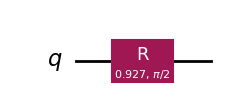

Circuit 1:


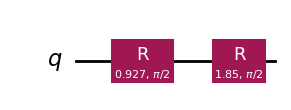

Circuit 2:


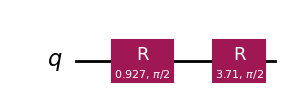

Circuit 3:


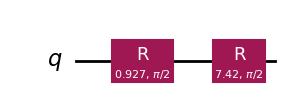

In [11]:
from qiskit_algorithms import MaximumLikelihoodAmplitudeEstimation

mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,
    sampler=sampler,
)
mlae_res = mlae.estimate(problem)
print(mlae_res)

print("\nEstimate:", mlae_res.estimation)

mlae_circuit = mlae.construct_circuits(problem)
# print(mlae_circuit)
# mlae_circuit.decompose().draw(output="mpl")

for i, circ in enumerate(mlae_circuit):
    print(f"Circuit {i}:")
    display(circ.decompose().draw(output="mpl"))


#### **4. Faster AE**

---




Faster Amplitude Estimation is optimized for **speed**, minimizing the number of oracle calls, making it highly suitable for practical near-term use.

<br>

**Key Idea**

- Skip Quantum Phase Estimation entirely  
- Reduce circuit depth drastically  
- Use randomized Grover powers and statistical inference to approximate the amplitude efficiently

In other words:

$$
\text{Minimal circuit depth} \;+\; \text{smart sampling} \;\Rightarrow\; \text{fast amplitude estimation}.
$$

<br>

**Pros**

- Requires **very few** oracle queries  
- **Shallowest circuits** among all AE variants  
- Great for **QML**, **quantum finance**, and other speed-sensitive applications  
- Very NISQ-friendly

<br>

**Cons**

- Slightly less accurate than IAE/MLAE  
- Mathematical justification is more complex under the hood

---

{   'circuit_results': None,
    'confidence_interval': (0.18456831462004966, 0.21927618814724328),
    'confidence_interval_processed': <generator object FasterAmplitudeEstimation.estimate.<locals>.<genexpr> at 0x16ad5b920>,
    'estimation': 0.20155346086326248,
    'estimation_processed': 0.20155346086326248,
    'num_first_state_steps': 3,
    'num_oracle_queries': 175083,
    'num_steps': 3,
    'post_processing': None,
    'shots': None,
    'success_probability': 0.97,
    'theta_intervals': [   [0, 0.25268025514207865],
                           [0.08775051237823216, 0.13082404080227913],
                           [0.10224985331227898, 0.11981371508796035],
                           [0.10761110847083782, 0.11733639788395493]]}

Estimate: 0.20155346086326248


/Users/shyam/Documents/Quantum-Inspired-Optimization/env/lib/python3.11/site-packages/qiskit_algorithms/amplitude_estimators/estimation_problem.py:214: UserWarning: Rescaling discards the Grover operator.
  warnings.warn("Rescaling discards the Grover operator.")


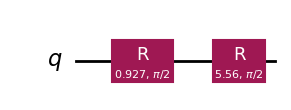

In [12]:
from qiskit_algorithms import FasterAmplitudeEstimation

fae = FasterAmplitudeEstimation(
    delta=0.01,
    maxiter=3,
    sampler=sampler,
)
fae_res = fae.estimate(problem)
print(fae_res)

print("\nEstimate:", fae_res.estimation)

fae_circuit = fae.construct_circuit(problem, k = 3)
fae_circuit.decompose().draw(output="mpl")

---

#### **5. Comparison of AE Variants**

---

<br>


| **Feature** | **Canonical AE** | **Iterative AE** | **MLAE** | **Faster AE** |
|-------------|------------------|------------------|----------|----------------|
| **Uses QFT?** | ✔️ | ❌ | ❌ | ❌ |
| **Controlled Grover powers?** | ✔️ | ❌ | ❌ | ❌ |
| **Circuit depth** | Very High | Medium | Low | Lowest |
| **Noise tolerance** | Poor | Medium | Excellent | Good |
| **Quantum speed (theoretical)** | Best | Good | Good | Best practical |
| **Classical post-processing** | Low | Medium | High | Medium |
| **Recommended for real devices?** | ❌ | ✔️ | ✔️ | ✔️ |
| **Best use case** | Theory, fault-tolerant QC | NISQ experiments | Noisy hardware | Speed-critical tasks |


---

----